In [1]:
from IPython.display import Audio 
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
import librosa
from pydub import AudioSegment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
from sys import getsizeof as m
%matplotlib inline

2022-01-23 15:44:55.344652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-23 15:44:55.344704: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [86]:

string = '3158hnjg reviews 58 89'
re.search(r'\d+', string).group(0)

'3158'

In [2]:
path_spoof = "idrd/Training_Data/spoof/"
path_human = "idrd/Training_Data/human/"
path_test = "idrd/Testing_Data/"

In [3]:
spoof_list_path = [path_spoof + i for i in os.listdir(path_spoof)]
human_list_path = [path_human + i for i in os.listdir(path_human)]
test_list_path = [path_test + i for i in os.listdir(path_test)]

In [142]:
def write_slice_audio(path_load, path_write, seconds):
    audio = AudioSegment.from_wav(path_load)
    n = re.search(r'\d+', path_load).group(0)
    start = 0
    end = seconds*1000 # ms
    for i in range(len(audio)//(seconds*1000)):
        slice_audio = audio[start:end]
        start = end
        end += seconds*1000
        slice_audio.export(f'{path_write}{n}.{i+1}.wav', format="wav")

In [143]:
[write_slice_audio(i, 'idrd/Slice_Training_Data/spoof/', 2) for i in tqdm(spoof_list_path)]
[write_slice_audio(i, 'idrd/Slice_Training_Data/human/', 2) for i in tqdm(human_list_path)]
[write_slice_audio(i, 'idrd/Slice_Testing_Data/', 2) for i in tqdm(test_list_path)]

100%|███████████████████████████████████████| 5000/5000 [01:32<00:00, 53.91it/s]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [4]:
path_spoof = "idrd/Slice_Training_Data/spoof/"
path_human = "idrd/Slice_Training_Data/human/"
path_test = "idrd/Slice_Testing_Data/"

spoof_list_path = [path_spoof + i for i in os.listdir(path_spoof)]
human_list_path = [path_human + i for i in os.listdir(path_human)]
test_list_path = [path_test + i for i in os.listdir(path_test)]

In [5]:
spoof_lables = [0]*len(spoof_list_path)
human_lables = [1]*len(human_list_path)

In [66]:
spoof_df = pd.DataFrame(list(zip(spoof_list_path, spoof_lables))).iloc[:17095,:]
human_df = pd.DataFrame(list(zip(human_list_path, human_lables))).iloc[:17095,:]
#human_df = pd.concat([human_df,human_df], ignore_index=True)
#human_df = pd.concat([human_df,human_df], ignore_index=True)
data_df = pd.concat([spoof_df,human_df], ignore_index=True)

In [67]:
data_df = shuffle(data_df)
train_data, test_data = train_test_split(data_df, train_size=0.7, stratify=data_df[1], random_state=0)
test_data, val_data = train_test_split(test_data, train_size=0.5, stratify=test_data[1], random_state=0)

In [8]:
train_data.iloc[0,0].shape

AttributeError: 'str' object has no attribute 'shape'

In [76]:
AUTOTUNE = tf.data.AUTOTUNE


def get_dataset(df):
    file_path_ds = tf.data.Dataset.from_tensor_slices(df[0])
    label_ds = tf.data.Dataset.from_tensor_slices(df[1])
    return tf.data.Dataset.zip((file_path_ds, label_ds))


def load_and_mel_spec_librosa(sounds):
    y,sr = librosa.load(sounds.numpy())
    y = np.hstack([np.array([0]*(223587-y.shape[0])), y])
    M = librosa.feature.melspectrogram(y=y, sr=sr)
    return tf.expand_dims(tf.constant(librosa.power_to_db(M, ref=np.max), dtype=tf.float32),-1)/255


def load_and_mel_spec(sounds):
    y = tfio.audio.AudioIOTensor(sounds).to_tensor()
    #y = tf.concat([tf.reshape(tf.constant([0]*(223587-y.shape[0]), dtype=tf.int16),[-1,1]), y], axis=0)
    y = tf.squeeze(y, -1)
    y = tf.cast(y, tf.float32)
    y = y/32768.0
    spectrogram = tfio.audio.spectrogram(y, nfft=512, window=512, stride=256)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    return tf.expand_dims(dbscale_mel_spectrogram, -1)/255
    #return tf.expand_dims(spectrogram, -1)/255


def prepare_for_training(ds, shuffle_buffer_size=1024, batch_size=256):
    # Randomly shuffle (file_path, label) dataset
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Load and decode audio from file paths
    ds = ds.map(lambda x,y: (tf.py_function(func=load_and_mel_spec, inp=[x], Tout=tf.float32), y,), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    # Prefetch
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

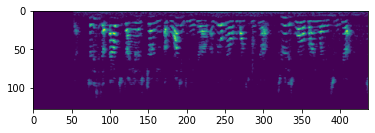

In [30]:
n = 0
spectrogram = mel_spec(train_data.iloc[n,0])
import librosa.display
plt.imshow(spectrogram)
#librosa.display.specshow(spectrogram)
#plt.colorbar()

In [122]:
c = [xx[i][0][0] for i in range(len(xx))]

In [124]:
max(c)

223587

In [125]:
min(c)

55566

In [128]:
import math
np.mean(c)

98204.2621

In [77]:
ds = get_dataset(train_data)
train_ds = prepare_for_training(ds)

ds = get_dataset(val_data)
val_ds = prepare_for_training(ds)

batch_size = 64

In [70]:
for i in train_ds:
    print(i[0].shape)
    break

(128, 125, 128, 1)


In [80]:
input_shape=(125, 128, 1)
input = keras.Input(shape=input_shape)
f = Conv2D(64, kernel_size=(3,3), activation='elu')(input)
f = Conv2D(32, kernel_size=(3,3), activation='elu')(f)
f = Conv2D(16, kernel_size=(5,5), activation='elu')(f)
f = Flatten()(f)
#attention()
d = Dense(320, activation='elu')(f)
d = Dense(160, activation='elu')(d)
d = Dense(1, activation='sigmoid')(d)

model = keras.Model(inputs=input, outputs=d)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["accuracy", TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives(),"AUC"])


In [ ]:
history = model.fit(train_ds, batch_size=256, epochs=10, validation_data=val_ds, shuffle=True)

Epoch 1/10
94/94 [==============================] - 2015s 21s/step - loss: 0.9003 - accuracy: 0.6013 - true_positives_12: 7073.0000 - true_negatives_12: 7319.0000 - false_positives_12: 4647.0000 - false_negatives_12: 4894.0000 - auc: 0.6278 - val_loss: 0.6127 - val_accuracy: 0.6526 - val_true_positives_12: 1412.0000 - val_true_negatives_12: 1935.0000 - val_false_positives_12: 630.0000 - val_false_negatives_12: 1152.0000 - val_auc: 0.7279
Epoch 2/10
94/94 [==============================] - 2020s 21s/step - loss: 0.5631 - accuracy: 0.7022 - true_positives_12: 8375.0000 - true_negatives_12: 8431.0000 - false_positives_12: 3535.0000 - false_negatives_12: 3592.0000 - auc: 0.7782 - val_loss: 0.5169 - val_accuracy: 0.7471 - val_true_positives_12: 2035.0000 - val_true_negatives_12: 1797.0000 - val_false_positives_12: 768.0000 - val_false_negatives_12: 529.0000 - val_auc: 0.8278
Epoch 3/10
94/94 [==============================] - 1984s 21s/step - loss: 0.4644 - accuracy: 0.7915 - true_positives

In [34]:
history.history

{'loss': [0.796087384223938],
 'accuracy': [0.793571412563324],
 'auc': [0.5],
 'val_loss': [0.7961267232894897],
 'val_accuracy': [0.7936000227928162],
 'val_auc': [0.5]}

In [64]:
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["accuracy", TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives(),"AUC"])

history = model.fit(train_ds, batch_size=batch_size, epochs=10, validation_data=val_ds, shuffle=True)

Epoch 1/10
110/110 [==============================] - 769s 7s/step - loss: 0.6899 - accuracy: 0.5444 - true_positives_7: 5322.0000 - true_negatives_7: 2300.0000 - false_positives_7: 4700.0000 - false_negatives_7: 1678.0000 - auc: 0.5601 - val_loss: 0.6926 - val_accuracy: 0.5000 - val_true_positives_7: 0.0000e+00 - val_true_negatives_7: 1500.0000 - val_false_positives_7: 0.0000e+00 - val_false_negatives_7: 1500.0000 - val_auc: 0.5060
Epoch 2/10
110/110 [==============================] - 624s 6s/step - loss: 0.6742 - accuracy: 0.5874 - true_positives_7: 4187.0000 - true_negatives_7: 4037.0000 - false_positives_7: 2963.0000 - false_negatives_7: 2813.0000 - auc: 0.6076 - val_loss: 0.6688 - val_accuracy: 0.6040 - val_true_positives_7: 1027.0000 - val_true_negatives_7: 785.0000 - val_false_positives_7: 715.0000 - val_false_negatives_7: 473.0000 - val_auc: 0.6295
Epoch 3/10
  4/110 [>.............................] - ETA: 8:17 - loss: 0.6340 - accuracy: 0.6699 - true_positives_7: 227.0000 - tr

KeyboardInterrupt: 

In [41]:
model.predict(load_and_mel_spec(train_data.iloc[0,0]))

ValueError: in user code:

    File "/home/alex/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/home/alex/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/alex/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/home/alex/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/home/alex/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/alex/.local/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 125, 128, 1), found shape=(None, 128, 1)


In [43]:
load_and_mel_spec(train_data.iloc[0,0])

<tf.Tensor: shape=(125, 128, 1), dtype=float32, numpy=
array([[[-0.29504648],
        [-0.03596584],
        [-0.07602798],
        ...,
        [-0.23916839],
        [-0.23174173],
        [-0.24159163]],

       [[-0.29504648],
        [-0.02407425],
        [-0.06413639],
        ...,
        [-0.24256808],
        [-0.26558077],
        [-0.22890805]],

       [[-0.29504648],
        [-0.01597229],
        [-0.05603442],
        ...,
        [-0.23383713],
        [-0.23849326],
        [-0.22716439]],

       ...,

       [[-0.29504648],
        [-0.00344255],
        [-0.04350469],
        ...,
        [-0.14395753],
        [-0.18288134],
        [-0.20734587]],

       [[-0.29504648],
        [-0.0170602 ],
        [-0.05712234],
        ...,
        [-0.24093822],
        [-0.24224696],
        [-0.2240806 ]],

       [[-0.29504648],
        [-0.0297166 ],
        [-0.06977873],
        ...,
        [-0.14578912],
        [-0.1460304 ],
        [-0.14501987]]], dtype=float32)

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
import tensorflow_io as tfio
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

path_spoof = "idrd/Training_Data/spoof/"
path_human = "idrd/Training_Data/human/"
path_test = "idrd/Testing_Data/"

spoof_list_path = [path_spoof + i for i in os.listdir(path_spoof)]
human_list_path = [path_human + i for i in os.listdir(path_human)]
test_list_path = [path_test + i for i in os.listdir(path_test)]

spoof_lables = [0]*len(spoof_list_path)
human_lables = [1]*len(human_list_path)

spoof_df = pd.DataFrame(list(zip(spoof_list_path, spoof_lables)))
human_df = pd.DataFrame(list(zip(human_list_path, human_lables)))
data_df = pd.concat([spoof_df,human_df], ignore_index=True)

data_df = shuffle(data_df)
train_data, test_data = train_test_split(data_df, train_size=0.7, stratify=data_df[1], random_state=0)
test_data, val_data = train_test_split(test_data, train_size=0.5, stratify=test_data[1], random_state=0)
AUTOTUNE = tf.data.AUTOTUNE


def get_dataset(df):
    file_path_ds = tf.data.Dataset.from_tensor_slices(df[0])
    label_ds = tf.data.Dataset.from_tensor_slices(df[1])
    return tf.data.Dataset.zip((file_path_ds, label_ds))


def load_and_mel_spec(sounds):
    y = tfio.audio.AudioIOTensor(sounds).to_tensor()
    if y.shape[0] >= 150000:
        y = y[:150000]
    else:
        y = tf.concat([tf.reshape(tf.constant([0]*(150000-y.shape[0]), dtype=tf.int16),[-1,1]), y], axis=0)
    y = tf.squeeze(y, -1)
    y = tf.cast(y, tf.float32)
    y = y/32768.0
    spectrogram = tfio.audio.spectrogram(y, nfft=512, window=512, stride=256)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    return tf.expand_dims(dbscale_mel_spectrogram, -1)


def prepare_for_training(ds, shuffle_buffer_size=1024, batch_size=64):
    # Randomly shuffle (file_path, label) dataset
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Load and decode audio from file paths
    ds = ds.map(lambda x,y: (tf.py_function(func=load_and_mel_spec, inp=[x], Tout=tf.float32), y,), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    # Prefetch
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds


ds = get_dataset(train_data)
train_ds = prepare_for_training(ds)

ds = get_dataset(val_data)
val_ds = prepare_for_training(ds)

batch_size = 64


output_bias = tf.keras.initializers.Constant(np.log([39678/10322]))
model = keras.Sequential([Conv2D(32, kernel_size=(3,3), input_shape=(586, 128, 1), activation='relu'),
                            Conv2D(16, kernel_size=(3,3), activation='relu'),
                            Flatten(),
                            Dense(32, activation='relu'),
                            Dense(1, activation='sigmoid', bias_initializer=output_bias)])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss=tfa.losses.SigmoidFocalCrossEntropy(), metrics=["accuracy","AUC"])


history = model.fit(train_ds, batch_size=64, epochs=1, validation_data=val_ds, shuffle=True)